#**Tarea Robótica Cognitiva**

#### **Nicolás Agustín Contreras Pérez**
Número de alumno: **17642647**

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

#Librerías y Funciones Importantes

In [ ]:
#@title Instalación de OpenPifPaf
!pip3 install -q openpifpaf==0.9.0

     |████████████████████████████████| 184kB 6.9MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 


In [ ]:
#@title Descarga de Dataset
!wget -q https://www.dropbox.com/s/hrhnsj7ko9xdtgz/surfers.png
!wget -q https://www.dropbox.com/s/858cf7xt93ladzf/4poses.zip
!unzip -q 4poses.zip

In [ ]:
#@title Configuraciones preliminares
import openpifpaf
from PIL import Image
import torch
import os
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("Current device set to " + ("GPU" if torch.cuda.is_available() else "CPU"))

def init_openpifpaf():
    #Función de inicialización de red neuronal
    net, _ = openpifpaf.network.factory()
    net = net.to(device)
    decode = openpifpaf.decoder.factory_decode(net, force_complete_pose=False, seed_threshold=0.5)
    processor = openpifpaf.decoder.Processor(net, decode, instance_threshold=0.2)
    return processor

def get_skeleton(net, img):
    #Función de extracción de esqueletos para una imagen
    data = openpifpaf.datasets.PilImageList([img])
    loader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)
    for images_batch, _, image_index in loader:
      images_batch = images_batch.to(device) 
      fields_batch = net.fields(images_batch)
      keypoint_sets, scores = net.keypoint_sets(fields_batch[0])
    return keypoint_sets

def draw_skeleton(net, img):
    #Función para dibujar los esqueletos detectados en una imagen
    data = openpifpaf.datasets.PilImageList([img])
    loader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)
    skeleton_painter = openpifpaf.show.KeypointPainter(
            show_box=False, color_connections=True, markersize=1, linewidth=6)
    for images_batch, _, image_index in loader:
      images_batch = images_batch.to(device) 
      fields_batch = net.fields(images_batch)
      predictions = net.annotations(fields_batch[0])
      with openpifpaf.show.image_canvas(img) as ax:
          skeleton_painter.annotations(ax, predictions)

opp_net = init_openpifpaf() # inicializa la red neuronal de pifpaf

Current device set to GPU


Downloading: "https://storage.googleapis.com/openpifpaf-pretrained/v0.8.0/resnet50block5-pif-paf-edge401-190625-025154-4e47f5ec.pkl" to /root/.cache/torch/checkpoints/resnet50block5-pif-paf-edge401-190625-025154-4e47f5ec.pkl


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `to

In [ ]:
def preprocessed_ds(opp_net):
    #Función para generar diccionarios con las características extraídas por la red neuronal
    train_set = {'persona_de_pie':[], 'persona_sentada':[], 'persona_de_pie_brazo_extendido':[], 'sin_persona':[]}
    test_set  = {'persona_de_pie':[], 'persona_sentada':[], 'persona_de_pie_brazo_extendido':[], 'sin_persona':[]}
    train_names = {'persona_de_pie':[], 'persona_sentada':[], 'persona_de_pie_brazo_extendido':[], 'sin_persona':[]}
    test_names  = {'persona_de_pie':[], 'persona_sentada':[], 'persona_de_pie_brazo_extendido':[], 'sin_persona':[]}

    for root, dirs, files in os.walk('4poses'):
      cat = root.split('/')
      for name in files:
        img = Image.open(os.path.join(root, name))
        skeletons = get_skeleton(opp_net, img)
        if cat[1] == 'train':
          train_set[cat[2]].append(skeletons)
          train_names[cat[2]].append(name)
        if cat[1] == 'test':
          test_set[cat[2]].append(skeletons)
          test_names[cat[2]].append(name)

    return train_set, test_set, train_names, test_names


##**Actividad 1**

Se utilizan las funciones implementadas del framework Open Pif Paf para extraer los modelos de esqueleto. Además, Se construye la matriz de caracterı́sticas y el vector de etiquetas para entrenar el modelo. 

Con la finalidad de mejorar el desempeño del clasificador, se calculan caracterı́sticas independientes para cada posición como los ángulos entre las articulaciones y distancias importantes entre puntos del esqueleto.


In [ ]:
# Lectura de datos, trazar esqueletos mediante la red neuronal y separación en set de train y test.
train_set, test_set, train_names, test_names = preprocessed_ds(opp_net)

In [ ]:
from math import acos, pi, sqrt

""" Funciones para extraer características de los esqueletos """

def modulo_vector(vector):
  # Determina el módulo de un vector.
  return sqrt(vector[0] ** 2 + vector[1] ** 2)

def dist_puntos(pto1, pto2):
  # Determina la distancia entre dos puntos.
  return sqrt((pto1[0] - pto2[0]) ** 2 + (pto1[1] - pto2[1]) ** 2)


def angulo_vectores(punto_centro, pto1, pto2):
  # Calcula el ángulo entre dos puntos c/r a un tercer punto.
  new_pto1 = [pto1[0] - punto_centro[0], pto1[1] - punto_centro[1]]
  new_pto2 = [pto2[0] - punto_centro[0], pto2[1] - punto_centro[1]]
  A_por_B = new_pto1[0] * new_pto2[0] + new_pto1[1] * new_pto2[1]
  modulo_A = modulo_vector(new_pto1)
  modulo_B = modulo_vector(new_pto2)
  return acos(A_por_B / (modulo_A * modulo_B)) * 180 / pi


In [ ]:
""" Función que determina las características más importantes de un set de datos completo 
    - toma en cuenta los ouliers """

def vectores_de_caracteristicas(matriz):
  x = []  # Arreglo con las características.
  y = []  # Arreglo con las soluciones/respuestas de x.
  for key in matriz.keys():
    for img in matriz[key]:
      if len(img) != 0: 
        caracteristicas = []
        # Cálculo de carcterísticas 
        caracteristicas.append(angulo_vectores(img[0][6], img[0][12], img[0][10]))  # Nariz, Cadera derecha y Mano derecha.
        caracteristicas.append(angulo_vectores(img[0][5], img[0][11], img[0][9]))  # Nariz, Cadera_izq y Mano izquierda.
        caracteristicas.append(angulo_vectores(img[0][14], img[0][10], img[0][16]))  # Rodilla derecha, Cadera derecha, Pie derecho.
        caracteristicas.append(angulo_vectores(img[0][13], img[0][9], img[0][15]))  # Rodilla izquierda, Cadera izquierda, Pie izquierdo.
        caracteristicas.append(angulo_vectores(img[0][6], img[0][10], img[0][16]))  # Hombro derecho, Mano derecha y Pie dereccho.
        caracteristicas.append(angulo_vectores(img[0][5], img[0][9], img[0][15]))  # Hombro izquierdo, Mano izquierda y Pie izquierdo.
        caracteristicas.append(dist_puntos(img[0][0], img[0][16]) * 2)  # Nariz - Pie derecho.
        caracteristicas.append(dist_puntos(img[0][0], img[0][15])  * 2)  # Nariz - Pie izquierdo.
        caracteristicas.append(dist_puntos(img[0][13], img[0][9]) * 2)  # Rodilla izquierda - Mano izquierda. 
        caracteristicas.append(dist_puntos(img[0][14], img[0][10]) * 2)  # Rodilla derecha - Mano derecha.
        caracteristicas.append(dist_puntos(img[0][8], img[0][12]) * 2)  # Codo derecho - Cadera derecha.
        caracteristicas.append(dist_puntos(img[0][7], img[0][11]) * 2)  # Codo izquierdo - Cadera izquierda.
        caracteristicas.append(dist_puntos(img[0][10], img[0][16]))  # Mano derecha - Pie derecho.
        caracteristicas.append(dist_puntos(img[0][9], img[0][15]))  # Mano izquierda - Pie izquierdo.
        caracteristicas.append(dist_puntos(img[0][7], img[0][13]))  # Codo izquierdo - Rodilla izquierda.
        caracteristicas.append(dist_puntos(img[0][8], img[0][14]))  # Codo derecho - Rodilla derecha.
        x.append(caracteristicas)
      else:
        x.append([-100] * 16)  # -100 si no hay esqueleto.
      y.append(key)
  return x, y

*   Las característcas se multiplican por 2 para que su aporte sea más significativo.
*   Cuando la imagen es sin_persona, se setea un valor negativo (-100) para que se encuentre separado de los valores de los otros datos y el algoritmo pueda separar los datos de mejor manera.



In [ ]:
""" Creación de matriz de características y del array de soluciones para 
    los sets de training y testing """

features_train, train_true = vectores_de_caracteristicas(train_set)
features_test, test_true = vectores_de_caracteristicas(test_set) 

In [ ]:
from sklearn.svm import SVC

""" Creación del clasificador y entrenamiento"""

params = {'C': 1.0, 'kernel': 'linear', 'gamma': 'scale'}
classifier_linear = SVC(**params)

classifier_linear.fit(features_train, train_true)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
""" Realización de predicciones con datos de testing y de entrenamiento """

y_test_pred_linear = classifier_linear.predict(features_test)
y_train_pred_linear = classifier_linear.predict(features_train)

## **Actividad 3**

Se documentan los resultados utilizando el nivel de exactitud reportado para los sets de testing y entrenamiento.

In [ ]:
from sklearn.metrics import accuracy_score

""" Determinación de la exactitud en testing """

accuracy_score(test_true, y_test_pred_linear)

0.8717948717948718

In [ ]:
""" Determinación de la exactitud en training """

accuracy_score(train_true, y_train_pred_linear)

0.8888888888888888

Los resultados obtenidos para el nivel de exactitud son 87.2% en testing y 88.9% en training. El resultado en training es ligeramente mejor que en testing. Los porcentajes obtenidos están determinados por varias situaciones o condiciones a las que puede estar sujeto el set de datos o el predictor. Entre ellas se encuentran  la cantidad de datos a predecir, falta de aleatoriedad en los datos de testing, figuras mal etiquetadas por la red neuronal, imágenes mal etiquetas dentro de las carpetas entregadas  y/o overfitting.

Analizando la **cantidad de datos** usados en testing y en training, es normal usar aproximadamente 80% de datos para entrenamiento y el 20% en testing (sin usar set de validación). Específicamente se usan 81 imagenes para training y 39 para testing, es decir, 67.5% y 32.5% respectivamente. Dichos porcentajes de datos se encuentra dentro de lo normalmente aceptado, pero puede que la cantidad total de datos en sí sea insuficiente para afirmar que el 87.2% de exactitud obtenido en testing, sea también obtenido con otros o más datos. Según la teoría de los grandes números, usada en teoría de probabilidades, mientras más sea la cantidad de datos, más se acercará a un valor que represente realmente el desempeño, en este caso, del estimador SVM.

Por otro lado, otro factor importante a tener en cuenta al analizar la exactitud del clasificador, es la **aleatoriedad de los datos**. En esta tarea los datos ya se encuentran separados en train y test, por lo que la función *preprocessed_ds()* solo pasa las imágenes por la red neuronal y entrega los sets separados. De esta forma, para analizar la aleatoriedad de las fotos hay que hacerlo de manera subjetiva: mirar las imágenes entregadas, y comparar el contenido de las carpetas *train* y *test* entregadas para la tarea. 

Realizando lo mencionado anteriormente, se nota que las imágenes en general y entre sets son bastante aleatorias. Cada carpeta posee imágenes en las que hay personas en distintas posiciones y sectores de la foto. De esta forma, la aleatoriedad no sería un factor que perjudique o facilite las predicciones.

En cuanto a **figuras mal etiquetadas por la red neuronal**, esto si sucede, y es analizado a fondo en la **Actividad 4**. En resumen, si una foto es mal etiquetada por la red neuronal, los datos estarán mal clasificados antes de realizar el entrenamiento del clasificador mediante *classifier.fit()*, y una vez entrenado, el algoritmos de aprendizaje supervisado SVM, hará separaciones de datos sesgadas. Dado que la red neuronal no siempre crea esqueletos correctos, no es posible alcanzar un 100% de exactitud (o un valor cercano), sin retirar los *outliers* presentes en los sets de datos. Ejemplos de figuras mal etiquetadas son las imágenes train_set/persona_de_pie/ 000835 y 000847 o test_set/persona_de_pie 000049.

Si hay **imágenes mal etiquetas dentro de las carpetas entregadas**, también causa que no se pueda alcanzar un 100% de exactitud del clasificador. Ejemplo de lo mencionado son las imágenes train/sin_persona/ 000043 y 000551. Dichas imágenes están en la carpeta sin_persona del set de training, pero realmente sí hay una persona a la que se le pueden distinguir sus articulaciones, y por lo tanto la red neuronal encuentra un esqueleto en las imágenes.

Por último, otro factor o situación que puede afectar la predicción del clasificador es el ***overfitting***. En simples palabras es sobreentrenar el algoritmo de aprendizaje con datos para los que se conoce el resultado deseado. Esto se arregla usando datos aleatorios para los distintos tests, y además se puede usar un set de validación para analizar de mejor manera lo entrenado y los resultados obtenidos. A simple vista, esto no sucede, ya que los resultados de exactitud para trainig y testing son bastante parecidos y no hay una diferencia muy significativa en cuanto a sus valores.

Con la finalidad de mejorar el clasificador, entrenándolo con datos correctamente etiquetados, se retiran los *outliers*. Estos son las imágenes **mal etiquetadas por la red neuronal** y **mal etiquetas dentro de las carpetas entregadas**, como se mencionó previamente.

Lo mencionado se realiza editando la función *vectores_de_caracteristicas()*, de manera que no tome en cuenta los *outliers*. Esto se realiza ignorando los datos cuando la red neuronal no encuentra esqueletos y no está etiquetado como 'sin_persona', y cuando escuentra un esqueleto y está etiquetado como 'sin_persona'.

In [ ]:
""" Función que determina las características más importantes de un set de datos completo 
    - no toma en cuenta los ouliers """

def vectores_de_caracteristicas2(matriz):
  x = []  # Arreglo con las características.
  y = []  # Arreglo con las soluciones/respuestas de x.
  for key in matriz.keys():
    for img in matriz[key]:
      if len(img) != 0 and key != 'sin_persona': 
        caracteristicas = []
        # Cálculo de carcterísticas 
        caracteristicas.append(angulo_vectores(img[0][6], img[0][10], img[0][16]))  # Hombro derecho, Mano derecha y Pie derecho.
        caracteristicas.append(angulo_vectores(img[0][5], img[0][9], img[0][15]))  # Hombro izquierdo, Mano izquierda y Pie izquierdo.
        caracteristicas.append(dist_puntos(img[0][0], img[0][16]) * 2)  # Nariz - Pie derecho.
        caracteristicas.append(dist_puntos(img[0][0], img[0][15])  * 2)  # Nariz - Pie izquierdo.
        caracteristicas.append(dist_puntos(img[0][13], img[0][9]) * 2)  # Rodilla izquierda - Mano izquierda 
        caracteristicas.append(dist_puntos(img[0][14], img[0][10]) * 2)  # Rodilla derecha - Mano derecha
        caracteristicas.append(dist_puntos(img[0][8], img[0][12]) * 2)  # Codo derecho - Cadera derecha
        caracteristicas.append(dist_puntos(img[0][7], img[0][11]) * 2)  # Codo izquierdo - Cadera izquierda.
        caracteristicas.append(dist_puntos(img[0][10], img[0][16]) * 2)  # Mano derecha - Pie derecho. 
        caracteristicas.append(dist_puntos(img[0][9], img[0][15]) * 2)  # Mano izquierda - Pie izquierdo.
        caracteristicas.append(dist_puntos(img[0][7], img[0][13]) * 2)  # Codo izquierdo - Rodilla izquierda.
        caracteristicas.append(dist_puntos(img[0][8], img[0][14]) * 2)  # Codo derecho - Rodilla derecha.
        x.append(caracteristicas)
        y.append(key)
      elif len(img) == 0 and key == 'sin_persona': 
        x.append([-100] * 12)
        y.append(key)
  return x, y



*   Al sacar los *outliers*, son menos las características necesarias para obtener un buen desempeño del clasificador, por lo que se eliminan 4 característcias anteriormente utilizadas.



In [ ]:
""" Creación de la matriz de características y del array de soluciones para 
    los sets de training y testing """

features_train2, train_true2 = vectores_de_caracteristicas2(train_set)
features_test2, test_true2 = vectores_de_caracteristicas2(test_set) 

In [ ]:
""" Creación del clasificador y entrenamiento"""

params = {'C': 1.0, 'kernel': 'linear', 'gamma': 'scale'}
classifier_linear2 = SVC(**params)

classifier_linear2.fit(features_train2, train_true2)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
""" Realización de predicciones con datos de testing y de entrenamiento """

y_test_pred_linear2 = classifier_linear2.predict(features_test2)
y_train_pred_linear2 = classifier_linear2.predict(features_train2)

In [ ]:
accuracy_score(test_true2, y_test_pred_linear2)

0.9714285714285714

In [ ]:
accuracy_score(train_true2, y_train_pred_linear2)

1.0

Con los cambios realizados, se obtiene un 100% de exactitud en training y un 97.1% en testing. El potencial cambio se debe principalmente por ignorar los *outliers* y por optimizar la extracción de características del clasificador. 

El 100% obtenido en training podría tratarse de *overfitting*, pero el rendimiento en set de testing también es muy cercano a 100%, por lo que se descarta dicha idea.

Los rendimientos obtenidos se deben principalmente a una búsqueda exahustiva de características, dados los esqueletos formados por la red neuronal. Es muy probable que si se prueba con más imágenes, el rendimiento baje un poco, alcanzando un porcentaje de rendimiento más representativo para  el clasificador. Lo mejor sería probar el clasificador mediante un set de validación para descartar posible *overfitting* u otras comportamientos indeseados del clasificador.


##**Actividad 4**


Se analizan las matrices de confusión obtenidas con las predicciones de los datos de testing y training, tomando el set completo de datos (con outliers).

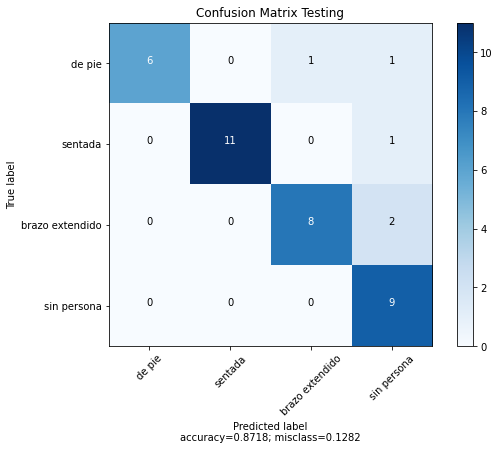

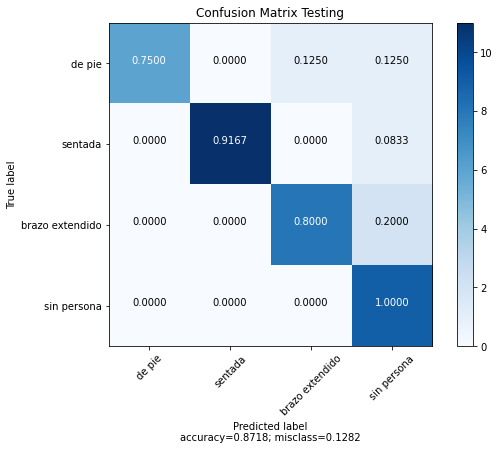

In [ ]:
from sklearn.metrics import confusion_matrix

""" Matriz de confusión con datos de Testing """

cm = confusion_matrix(test_true, y_test_pred_linear)
plot_confusion_matrix(cm, ['de pie', 'sentada', 'brazo extendido', 'sin persona'], title="Confusion Matrix Testing")
plot_confusion_matrix(cm, ['de pie', 'sentada', 'brazo extendido', 'sin persona'], title="Confusion Matrix Testing", normalize=True)

Dada la matriz de confusión generada con los datos de testing, es posible apreciar que el mejor rendimiento lo posee la categoría 'sin_persona', en la que todas sus predicciones fueran correctamente acertadas.
Por otro lado, el error más común es confundir una persona con brazo extendido, con una imagen sin persona, con dos errores. Esto también se repite para las demás categorías, que también poseen predicciones erróneas clasificando imágenes como 'sin persona'.
La categoría con más bajo rendimiento es 'de_pie', con un rendimiento de 75%. Dos de sus etiquetas se clasifican de forma erronea, una como brazo_extendido y otra como sin_persona.
Por último, el error más común en general, es catalogar imágenes como 'sin_persona' sin pertenecer a dicha categoría.

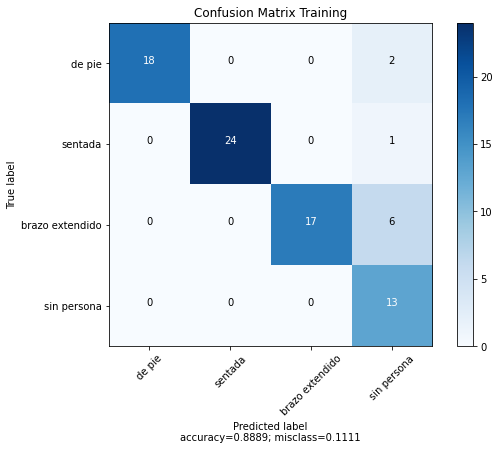

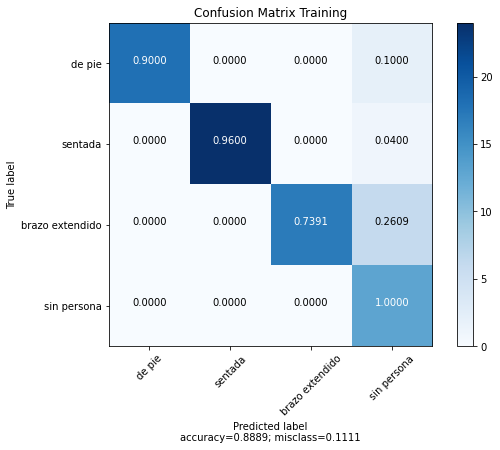

In [ ]:
""" Matriz de confusión con datos de Training """

cm2 = confusion_matrix(train_true, y_train_pred_linear)
plot_confusion_matrix(cm2, ['de pie', 'sentada', 'brazo extendido', 'sin persona'], title="Confusion Matrix Training")
plot_confusion_matrix(cm2, ['de pie', 'sentada', 'brazo extendido', 'sin persona'], title="Confusion Matrix Training", normalize=True)

En cuanto a la matriz de confusión generada con los datos de training, es posible notar que la categoría con mejor rendimiento es 'sin_persona', encontrando todas las imágenes que corresponden a dicha categoría. Por otro lado, el error más frecuente es clasificar una imagen con brazo extendido como 'sin_persona', al igual que los resultados de testing, pero esta vez con 6 errores. Además, la categoría con más bajo rendimiento es 'brazo_extendido', acumulando 5 errores en sus predicciones y un 74% de rendimiento. Por último, al igual que en la matriz de testing, el error general que más se repite es es catalogar imágenes como 'sin_persona' sin pertenecer a dicha categoría.

Los errores cometidos por el clasificador son causados principalmente por equivocaciones de la red neuronal. Analizando las fotos y procesándolas mediante la red neuronal, es posible notar que hay imágenes en las que no detecta a la persona. Esto se debe a que no muestra todas sus articulaciones de manera que puedan ser reconocidas por el algoritmo. Ejemplos de lo analizado son los siguientes: 

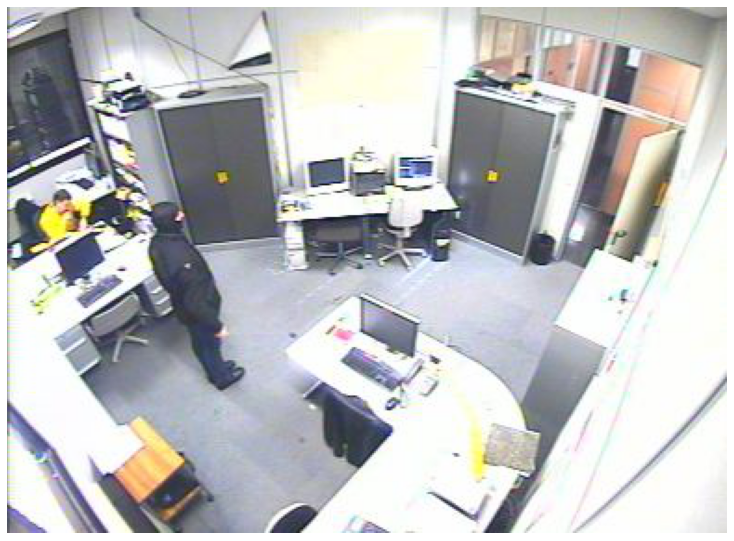

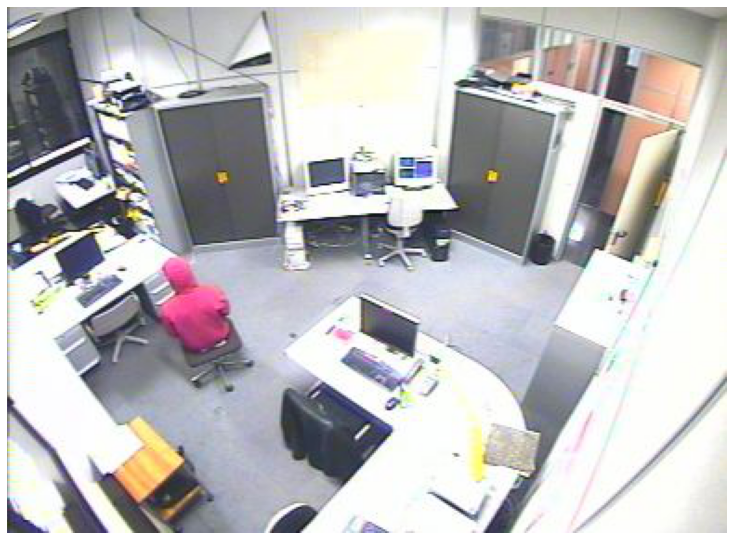

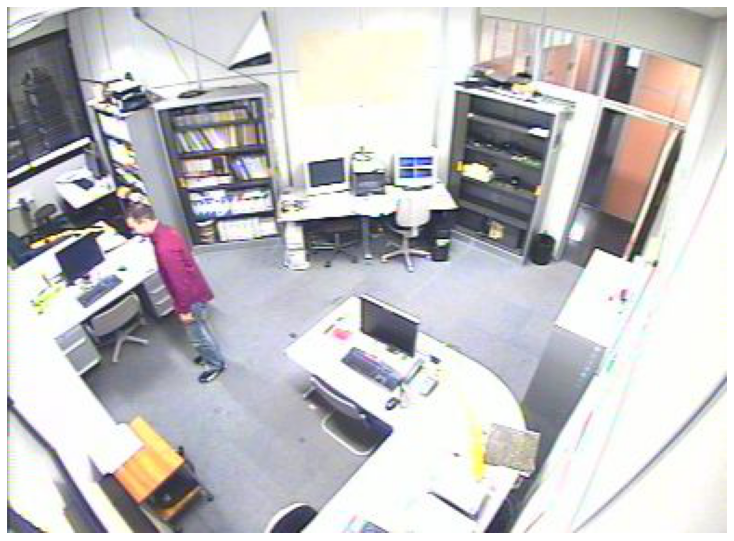

In [ ]:
imgp1 = Image.open('4poses/train/persona_de_pie/000835.jpg')
draw_skeleton(opp_net, imgp1)
imgp2 = Image.open('4poses/train/persona_sentada/000138.jpg')
draw_skeleton(opp_net, imgp2)
imgp3 = Image.open('4poses/train/persona_de_pie/000847.jpg')
draw_skeleton(opp_net, imgp3)

En la celda de código anterior, hay tres ejemplos de imágenes que sí poseen personas, pero no son reconocidas por el algoritmo. Esto provoca que lo vectores usados para entrenar al clasificador, poseean más dispersión de lo esperado, y por lo tanto, las rectas usadas para categorizar los vectores, tomen datos correspondientes a categorías erróneas. Así mismo, no es posible esperar que el clasificador llegue a un 100% de exactitud, pero si se puede mejorar tomando en cuenta características más apropiadas o que se enfoquen en los principales errores como de_pie - brazo_extendido o de_pie - sentado.

Al retirar los outliers es posible apreciar que los errores disminuyen considerablemente:

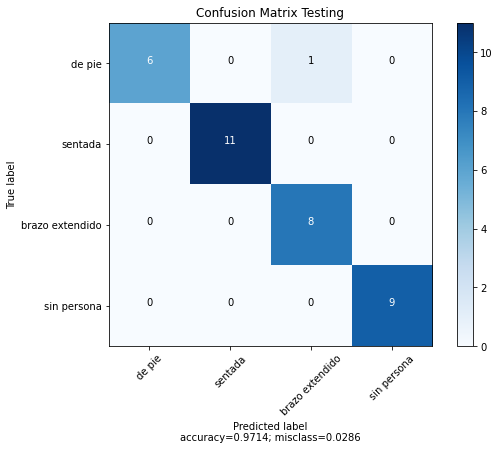

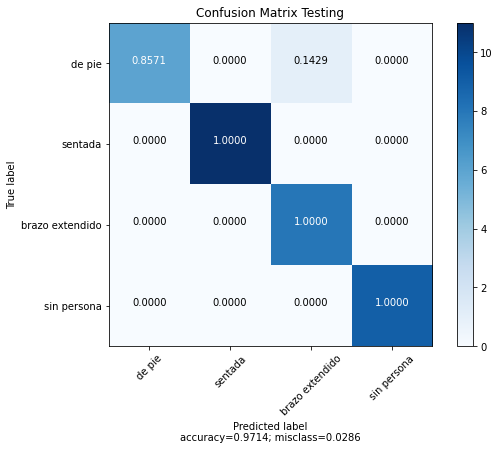

In [ ]:
from sklearn.metrics import confusion_matrix

""" Matriz de confusión con datos de Testing """

cm3 = confusion_matrix(test_true2, y_test_pred_linear2)
plot_confusion_matrix(cm3, ['de pie', 'sentada', 'brazo extendido', 'sin persona'], title="Confusion Matrix Testing")
plot_confusion_matrix(cm3, ['de pie', 'sentada', 'brazo extendido', 'sin persona'], title="Confusion Matrix Testing", normalize=True)

En esta oportunidad, solo hay un error en el set de testing: catalogar una persona **de pi**e como una persona con **brazo extendido**. Es posible notar que ya no hay errores al confundir imágenes con la clase sin_persona. 

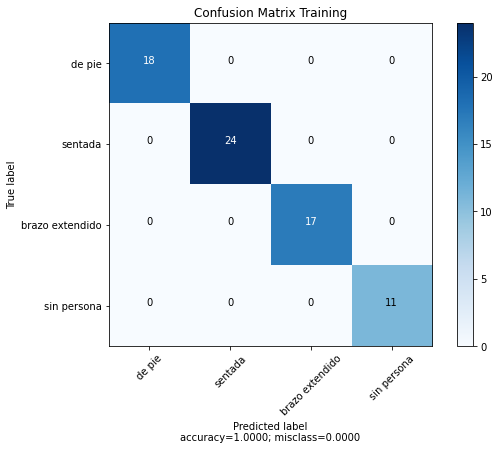

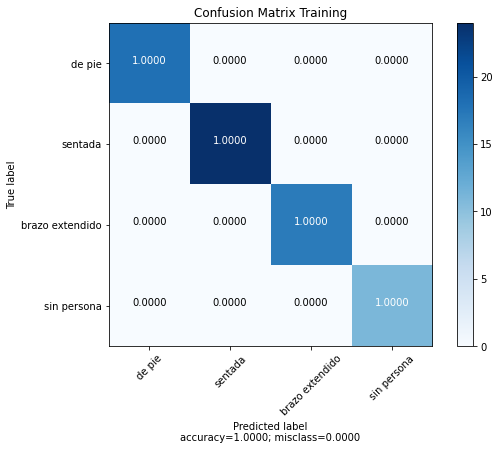

In [ ]:
""" Matriz de confusión con datos de Training """

cm4 = confusion_matrix(train_true2, y_train_pred_linear2)
plot_confusion_matrix(cm4, ['de pie', 'sentada', 'brazo extendido', 'sin persona'], title="Confusion Matrix Training")
plot_confusion_matrix(cm4, ['de pie', 'sentada', 'brazo extendido', 'sin persona'], title="Confusion Matrix Training", normalize=True)

Esta última matriz muestra que no hay errores de predicción para el set de entrenamiento.

##**Actividad 2**

A continuación se muestran ejemplos de cada clase que haya sido procesado por la red neuronal. 

**Persona de pie**


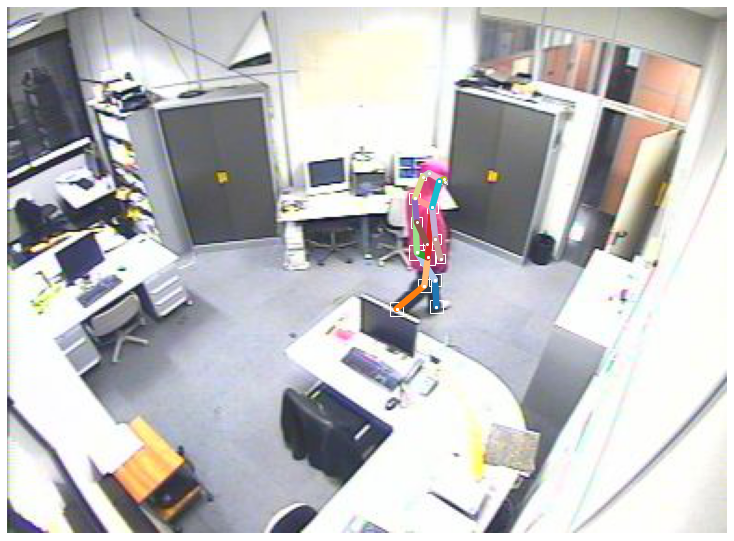

In [ ]:
imgp = Image.open('4poses/train/persona_de_pie/000561.jpg')
draw_skeleton(opp_net, imgp)

En la imagen mostrada es posible apreciar que la red neuronal encuentra la figura humana. Si bien la persona tiene su cara completamente tapada con un gorro, de igual manera se crean puntos para identificar su cara, dada una posición estimada de sus facciones. Esto se debe a que la red neuronal se fija en las articulaciones de un ser humano. De esta forma, zonas como las orejas, ojos o nariz, que es complicado distinguir o no se ven tan claras en una imagen, puedan ser estimadas sin ningún problema, dadas otras partes del cuerpo.

**Persona sentada**

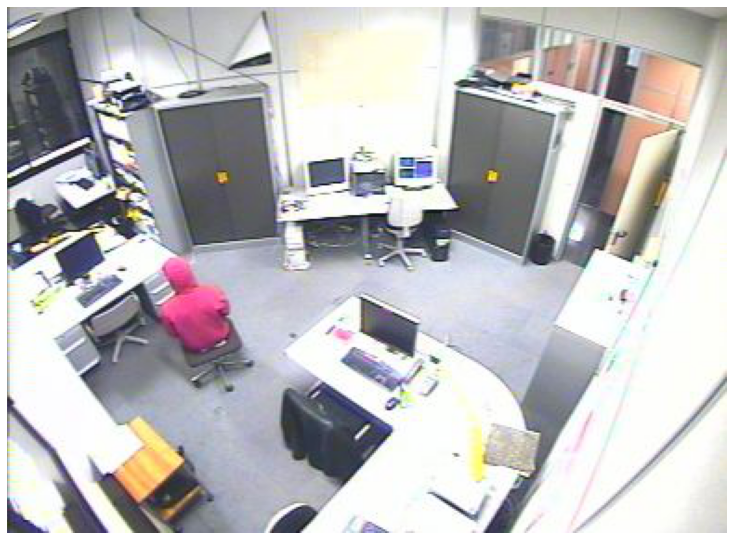

In [ ]:
imgp = Image.open('4poses/train/persona_sentada/000138.jpg')
draw_skeleton(opp_net, imgp)

En esta oportunidad, la red neuronal no ha determinado un esqueleto para la persona que se encuentra sentada de espaldas. Esto se debe a que faltaron datos para poder catalogar dicho espacio como parte de un esqueleto. Como se visualiza, solo se aprecia la espalda de la persona, no están sus brazos completos ni sus piernas. Lo mencionado, afirma el hecho de que falta información, ya que no se encuentran todas las articulaciones del ser humano en la fotografía.

**Persona de pie brazo extendido**

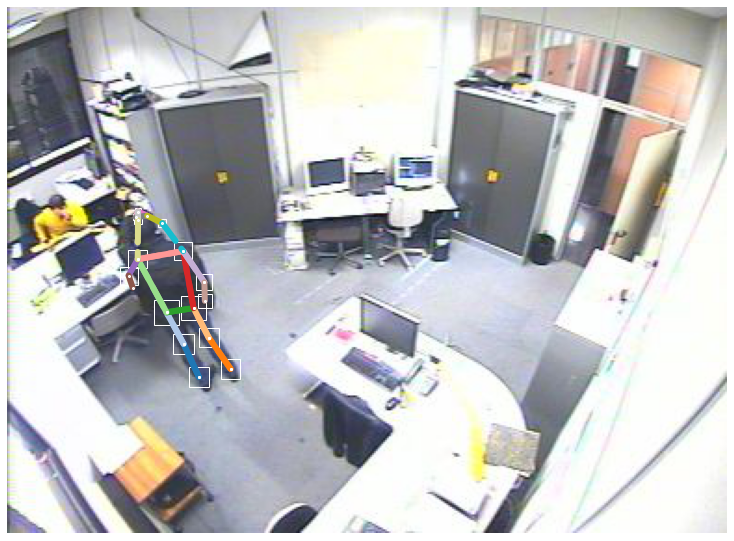

In [ ]:
imgp = Image.open('4poses/train/persona_de_pie_brazo_extendido/000337.jpg')
draw_skeleton(opp_net, imgp)

Si bien la red neuronal encuentra a la persona en la fotografía, no lo hace de forma completa. El brazo izquierdo, que se encuentra extendido hacia adelante, no es tomado en cuenta y es dibujado como los segmentos cortos de color morado y marrón. Esto se puede deber a una confusión por parte de la red neuronal; es probable que se confundiera la mano izquierda con los elementos presentes en el estante, y el color negro del brazo con otros colores que estén alrededor.

**Sin persona**

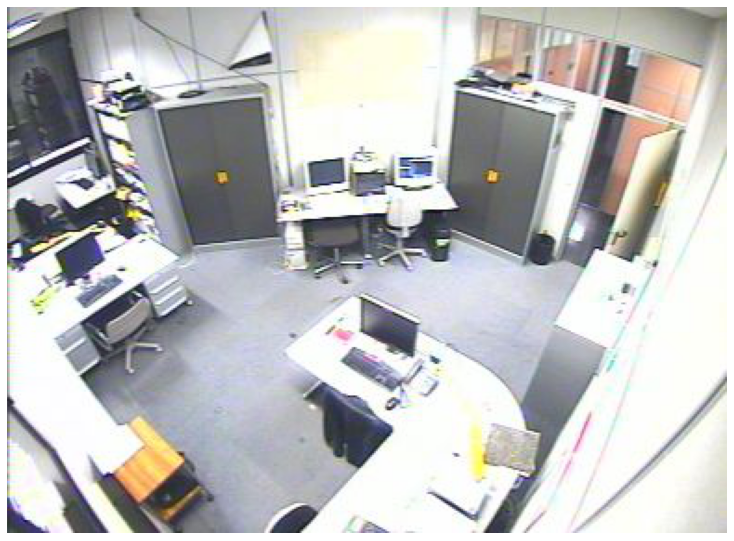

In [ ]:
imgp = Image.open('4poses/train/sin_persona/000036.jpg')
draw_skeleton(opp_net, imgp)

Como es posible visualizar, en esta última imagen no hay ningún ser humano, por lo que la red neuronal no dibuja ningún esqueleto. Esto es una prueba empírica de que la librería utilizada diferencia muy bien la existencia o no de personas en una imagen, y no las confunde con otros elementos presentes. La foto en sí muestra mucho contenido que podría ser malinterpretado, pero este no es el caso de la red neuronal utilizada.